### 이상탐지
제조 공정에서 들어오는 제조 데이터의 이상탐지와 ECG 이상탐지가 비슷할 것 같다. 진행해보자.

### ECG
ECG 신호(심전도)의 이상 징후를 탐지하는 목적은, 불규칙한 심박수 및 리듬을 찾는 것이다. 이 목적을 달성하기 위해서는 이상 징후 탐지 시스템이 모든 심장 박동 시퀀스에서 이상 징후를 찾을 수 있어야 하며, 필수 메트릭을 얻을 수 있어야 한다.

심전도는 심장의 리듬과 전기적 활동을 체크하는 데 사용될 수 있는 간단한 테스트이다. 피부에 부착된 센서는 심장이 뛸 때 마다 생성되는 전기 신호를 감지하는 데 사용한다.

### 필요 라이브러리 Import

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model

import warnings
warnings.filterwarnings('ignore')

In [2]:
origin_df = pd.read_csv("../data/ecg.csv")
new_value = pd.Series(origin_df.columns).to_frame().T
origin_df.columns = list(range(origin_df.shape[1]))

df = pd.concat([new_value, origin_df], axis=0)
df

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.11252183,-2.8272038,-3.7738969,-4.3497511,-4.376041,-3.4749863,-2.1814082,-1.8182865,-1.2505219,-0.47749208,...,0.79216787,0.93354122,0.79695779,0.57862066,0.2577399,0.22807718,0.12343082,0.92528624,0.19313742,1.0
0,-1.100878,-3.99684,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.75468,0.042321,...,0.538356,0.656881,0.78749,0.724046,0.555784,0.476333,0.77382,1.119621,-1.43625,1.0
1,-0.567088,-2.59345,-3.87423,-4.584095,-4.187449,-3.151462,-1.74294,-1.490659,-1.18358,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
2,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.88111,-2.99328,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
3,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.53451,-1.783423,-1.59445,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.97102,1.614392,1.421456,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4992,0.608558,-0.335651,-0.990948,-1.784153,-2.626145,-2.957065,-2.931897,-2.664816,-2.090137,-1.461841,...,1.757705,2.291923,2.704595,2.451519,2.017396,1.704358,1.688542,1.629593,1.342651,0.0
4993,-2.060402,-2.860116,-3.405074,-3.748719,-3.513561,-3.006545,-2.23485,-1.59327,-1.075279,-0.976047,...,1.388947,2.079675,2.433375,2.159484,1.819747,1.534767,1.696818,1.483832,1.047612,0.0
4994,-1.122969,-2.252925,-2.867628,-3.358605,-3.167849,-2.63836,-1.664162,-0.935655,-0.866953,-0.645363,...,-0.472419,-1.310147,-2.029521,-3.221294,-4.17679,-4.00972,-2.874136,-2.008369,-1.808334,0.0
4995,-0.547705,-1.889545,-2.839779,-3.457912,-3.929149,-3.966026,-3.49256,-2.69527,-1.849691,-1.374321,...,1.258419,1.90753,2.280888,1.895242,1.437702,1.193433,1.261335,1.150449,0.804932,0.0


In [3]:
data = df.iloc[:, :-1].values.astype(np.float32)
labels = df.iloc[:, -1].values.astype(np.float32)

labels

array([1., 1., 1., ..., 0., 0., 0.], dtype=float32)

In [4]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=705)

데이터를 normalizing 한다.

$$ X_{normalized} = {X-X_{min}\over X_{max} - X_{min}} $$

In [5]:
min = tf.reduce_min(train_data)  # Tensor 자료형 내 특정 축을 기준으로 최소값을 Tensor로 반환
max = tf.reduce_max(train_data)  # Tensor 자료형 내 특정 축을 기준으로 최대값을 Tensor로 반환

print(min, max)

train_data = (train_data - min) / (max - min)  # 정규화
test_data = (test_data - min ) / (max - min)  # 정규화

tf.Tensor(-6.092227, shape=(), dtype=float32) tf.Tensor(4.888192, shape=(), dtype=float32)


In [6]:
train_labels = train_labels.astype(bool)  # label들의 경우 2진값(0, 1)이기에 bool type으로 변경
test_labels = test_labels.astype(bool)

In [7]:
train_data.shape

TensorShape([3998, 140])

In [8]:
test_data.shape

TensorShape([1000, 140])

In [9]:
n_train_data = train_data[train_labels]  # ndarray[List[bool]] : 같은 인덱스 위치에 True인 값들만 배열 내에 남게 된다.
n_test_data = test_data[test_labels]  # 즉, 정상 신호만을 n_train_data, n_test_data에 남기게 됨

an_train_data = train_data[~train_labels]  # ~을 사용하여 부정형을 사용하기에, False데이터만을 배열 내에 남김
an_test_data = test_data[~test_labels]

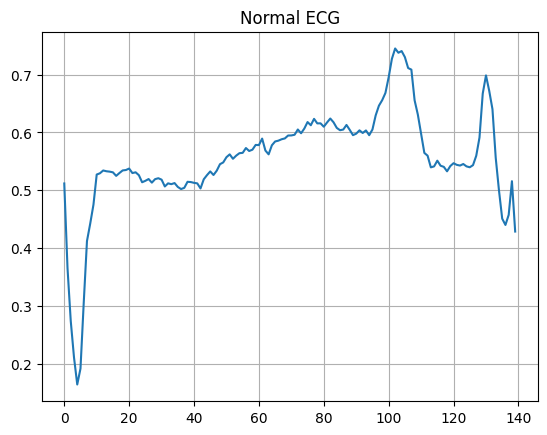

In [10]:
plt.plot(np.arange(140), n_train_data[0])  # 정상 데이터의 한 row를 시각화
plt.grid()
plt.title("Normal ECG")
plt.show()

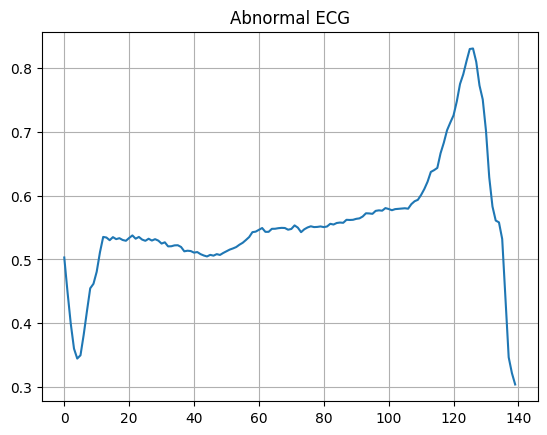

In [11]:
plt.plot(np.arange(140), an_train_data[0])  # 비정상 데이터의 한 row를 시각화
plt.grid()
plt.title("Abnormal ECG")
plt.show()

### Anomaly Detection with AutoEncoder

모델이 이상치를 탐지하는 원리는 다음과 같다.

1. Data가 input됨과 동시에 Encoding을 진행하면서 Down sampling 혹은 noise를 발생
2. Encoding이 완료된 시점에서 latent vector가 생성되며, 해당 latent vector는 decoder의 input으로 활용됨
3. decoding 단계에서는 Up sampling하며 low level의 latent vector를 복구함.
4. decoding이 완료된 시점에서는 input size와 동일한 vector가 reconstruct되며, decoder의 output vector와 encoder의 input vector간의 차이를 기반으로 이상치를 감지함.
    - 이 때 decoder의 output과 encoder의 input간의 차이를 `reconstruction error`라고 부르며, 특정 임계치를 기준으로 이상치를 판별함.

In [12]:
class detector(Model):
    """
    Auto Encoder모델을 keras.models의 Model을 Inheritance
    """
    def __init__(self):
        super(detector, self).__init__()
        self.encoder = tf.keras.Sequential([  # Encoder 정의
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")
        ])

        self.decoder = tf.keras.Sequential([  # Decoder 정의
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(140, activation="sigmoid")  # 본래 input shape인 140으로
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [13]:
autoencoder = detector()  # 모델의 뼈대만 생성하고
autoencoder.compile(optimizer="adam", loss='mae')  
autoencoder.fit(n_train_data, n_train_data, epochs=50, batch_size=512, validation_data=(n_test_data, n_test_data))  # 해당 시점에서 call 메소드가 동작하며 학습 시작

Epoch 1/50
5/5 [==============================] - 0s 27ms/step - loss: 0.0837 - val_loss: 0.0813
Epoch 2/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0804 - val_loss: 0.0785
Epoch 3/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0770 - val_loss: 0.0741
Epoch 4/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0722 - val_loss: 0.0688
Epoch 5/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0665 - val_loss: 0.0629
Epoch 6/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0604 - val_loss: 0.0568
Epoch 7/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0542 - val_loss: 0.0509
Epoch 8/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0487 - val_loss: 0.0460
Epoch 9/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0439 - val_loss: 0.0417
Epoch 10/50
5/5 [==============================] - 0s 5ms/step - loss: 0.0399 - val_loss: 0.0384
Epoch 11/50
5/5 [=====================

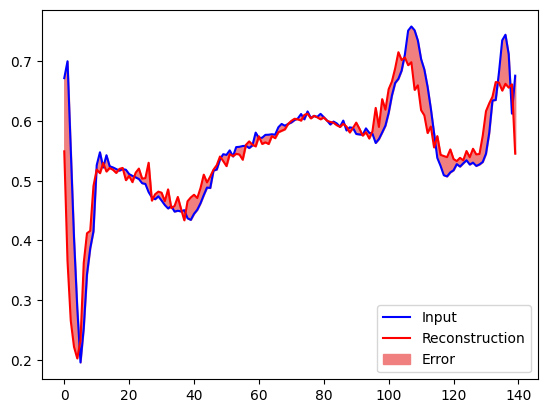

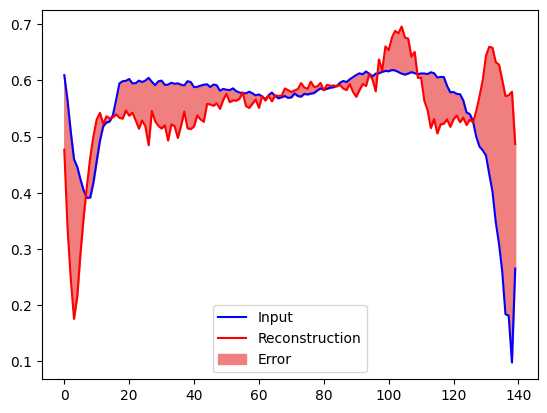

In [14]:
def plot(data, n):
    enc_img = autoencoder.encoder(data)
    dec_img = autoencoder.decoder(enc_img)

    plt.plot(data[n], 'b')
    plt.plot(dec_img[n], 'r')
    plt.fill_between(np.arange(140), data[n], dec_img[n], color='lightcoral')
    plt.legend(labels=['Input', 'Reconstruction', 'Error'])
    plt.show()

plot(n_test_data, 0)
plot(an_test_data, 0)

In [15]:
reconstructed = autoencoder(n_train_data)  # 해당 시점에서도 call 메소드 호출
train_loss = losses.mae(reconstructed, n_train_data)  # auto encoder로 인해 reconstruct된 데이터와 훈련 데이터 간의 reconstruction error를 계산
t = np.mean(train_loss) + np.std(train_loss)  # reconstruction error의 평균과 표준편차의 합으로 threshold를 설정

def prediction(model, data, threshold):
    rec = model(data)
    loss = losses.mae(rec, data)
    return tf.math.less(loss, threshold)

print(t)

0.036954485


### Threshold 설정

현재 예제에서는 임계치를 Reconstruction Error의 평균과 표준편차의 합으로 설정하고 있다. 이러한 방식으로 얻을 수 있는 이점은 아래와 같다.

1. 데이터셋의 특성 포함
    - 평균은 데이터셋 전체의 중앙 경향을 나타내며, 표준편차는 데이터의 분산 정도를 나타낸다.
    - 평균과 표준편차를 합함으로서 정상 데이터의 재구성 오류 분포를 고려한 임계치를 설정할 수 있다.
    - 이러한 임계치는 재구성 오류가 평균보다 약간 큰 경우(즉, 표준편차 범위 내)에 대해서는 정상 데이터로 간주하고, 그 범위를 벗어난 경우 비정상 데이터로 간주할 수 있게 한다.

2. 유연한 비정상 데이터 탐지
    - 평균과 표준편차를 이용한 임계치는 간단하면서도 효과적인 비정상 데이터 탐지 방법이다.
    - 이 방식은 재구성 오류가 정규분포를 따른다는 가정 하에, 평균에서 표준편차 범위를 벗어나는 데이터 포인트를 비정상으로 간주하여 탐지한다.
    

In [16]:
pred = prediction(autoencoder, n_test_data, t)
pred

<tf.Tensor: shape=(590,), dtype=bool, numpy=
array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True, False,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False,  True, False, False,  True,  True,  True,  True,
        True, False,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True, Fal

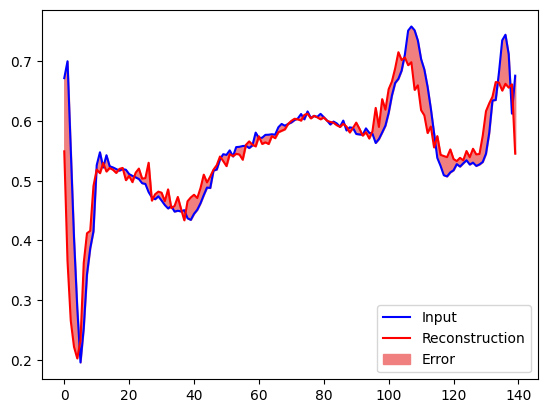

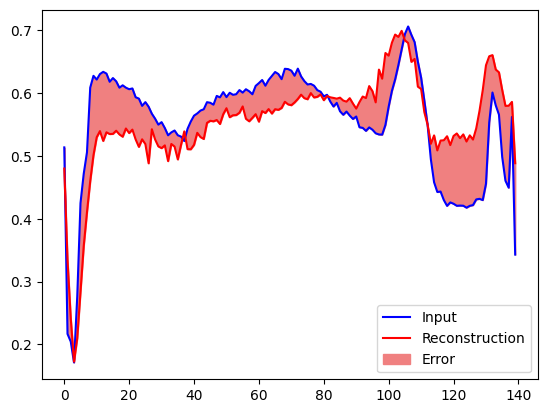

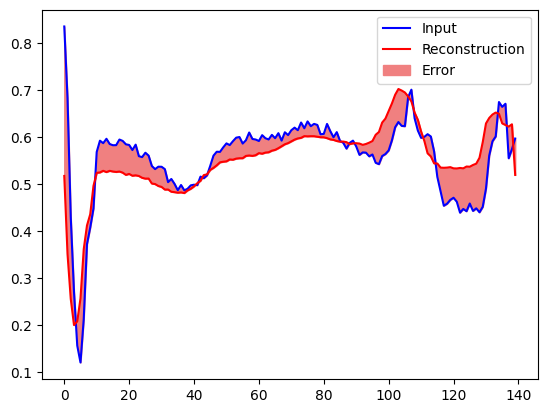

In [18]:
plot(n_test_data, 0)  # 정상 데이터
plot(n_test_data, 14)  # 비정상 데이터
plot(n_test_data, 16)  # 비정상 데이터